In this notebook we fit linear filters predicting neural activity from sensory inputs.

In [1]:
%matplotlib inline
from copy import deepcopy
from itertools import product as cproduct
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression, Ridge

from aux import Generic
from data import DataLoader, random_chunk_split
from db import make_session, d_models
from lin_fit import fit_h_train_test
from plot import set_font_size

import CONFIG as C

# Fit linear filters

In [2]:
TRAIN_LEN = 32  # s
TEST_LEN = 8  # s
WDW = (-3, 0)

EXPTS = ['white_odor_fluct']
GS = ['g2', 'g3', 'g4', 'g5']

X_NAMES = ['odor_binary', 'odor_pid', 'w_air', 'air']
Y_NAMES = sum([[g + sfx for g in GS] for sfx in 'rlsd'], [])

METHODS = {
    'odor_binary': 'built-in',
    'odor_pid': 'built-in',
    'w_air': 'built-in',
    'air': 'built-in',
}

PARAMS = {
    'odor_binary': {'model': LinearRegression},
    'odor_pid': {'model': LinearRegression},
    'w_air': {'model': lambda: Lasso(alpha=0.5)},
    'air': {'model': LinearRegression},
}

COLS = list(cproduct(X_NAMES, Y_NAMES))

BINS = np.linspace(-.1, 1, 111)
BINCS = 0.5 * (BINS[:-1] + BINS[1:])

COLORS = {
    'odor_binary': np.array(C.COLORS_RGB['odor_binary'])/255,
    'odor_pid': np.array(C.COLORS_RGB['odor_pid'])/255,
    'w_air': np.array(C.COLORS_RGB['w_air'])/255,
    'air': np.array([153, 51, 255])/255,
}

### Load trials

In [3]:
session = make_session()
trials = session.query(d_models.Trial).filter(
    d_models.Trial.expt.in_(EXPTS)).all()
session.close()

# load data and create a moving average 
for trial in trials:
    trial.dl = DataLoader(trial, 0, None)

### Fit filters

In [4]:
df_rslt = pd.DataFrame(columns=COLS, index=[trial.name for trial in trials])
df_r2 = pd.DataFrame(columns=COLS, index=[trial.name for trial in trials])
df_h = pd.DataFrame(columns=COLS, index=[trial.name for trial in trials])

for trial in trials:
    print('Fitting trial {}...'.format(trial.name))
    
    # loop over all x, y variable pairs
    for x_name, y_name in COLS:
        
        rslt = fit_h_train_test(
            trial=trial,
            x_names=[x_name],
            y_name=y_name,
            wdws={x_name: WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHODS[x_name],
            params=PARAMS[x_name],
            normed=False,
            C=C)
        
        df_rslt.loc[trial.name][(x_name, y_name)] = deepcopy(rslt)
        df_r2.loc[trial.name][(x_name, y_name)] = rslt.r2_test
        df_h.loc[trial.name][(x_name, y_name)] = np.array([rslt.t_hs, rslt.hs])

Fitting trial 20171130.Fly1.3...
Fitting trial 20171130.Fly1.4...
Fitting trial 20171130.Fly1.5...
Fitting trial 20171130.Fly1.6...
Fitting trial 20171130.Fly2.1...
Fitting trial 20171130.Fly2.2...
Fitting trial 20171130.Fly3.3...
Fitting trial 20171130.Fly3.4...
Fitting trial 20171130.Fly3.5...
Fitting trial 20171130.Fly3.6...
Fitting trial 20171130.Fly3.7...
Fitting trial 20171130.Fly4.4...
Fitting trial 20171130.Fly4.5...
Fitting trial 20171130.Fly4.6...
Fitting trial 20171130.Fly4.7...
Fitting trial 20171130.Fly4.8...
Fitting trial 20171130.Fly5.1...
Fitting trial 20171130.Fly5.2...
Fitting trial 20171130.Fly5.3...
Fitting trial 20171130.Fly5.4...
Fitting trial 20171130.Fly5.5...
Fitting trial 20171204.Fly2.3...
Fitting trial 20171204.Fly2.4...
Fitting trial 20171204.Fly2.5...
Fitting trial 20171204.Fly2.6...


# Plot R2 for different filter types

In [5]:
df_r2[('odor_pid', 'g4s')]

20171130.Fly1.3     0.249498
20171130.Fly1.4     0.054681
20171130.Fly1.5    0.0902283
20171130.Fly1.6   -0.0803959
20171130.Fly2.1     0.362075
20171130.Fly2.2      0.11396
20171130.Fly3.3     0.134528
20171130.Fly3.4   -0.0254406
20171130.Fly3.5    0.0324817
20171130.Fly3.6     0.107136
20171130.Fly3.7      0.12766
20171130.Fly4.4     0.199686
20171130.Fly4.5     0.168556
20171130.Fly4.6   -0.0794933
20171130.Fly4.7     0.106213
20171130.Fly4.8   -0.0802329
20171130.Fly5.1    0.0773218
20171130.Fly5.2     0.409734
20171130.Fly5.3    -0.185405
20171130.Fly5.4    -0.147611
20171130.Fly5.5     0.306275
20171204.Fly2.3   -0.0624248
20171204.Fly2.4     0.197069
20171204.Fly2.5    -0.520368
20171204.Fly2.6    0.0601467
Name: (odor_pid, g4s), dtype: object

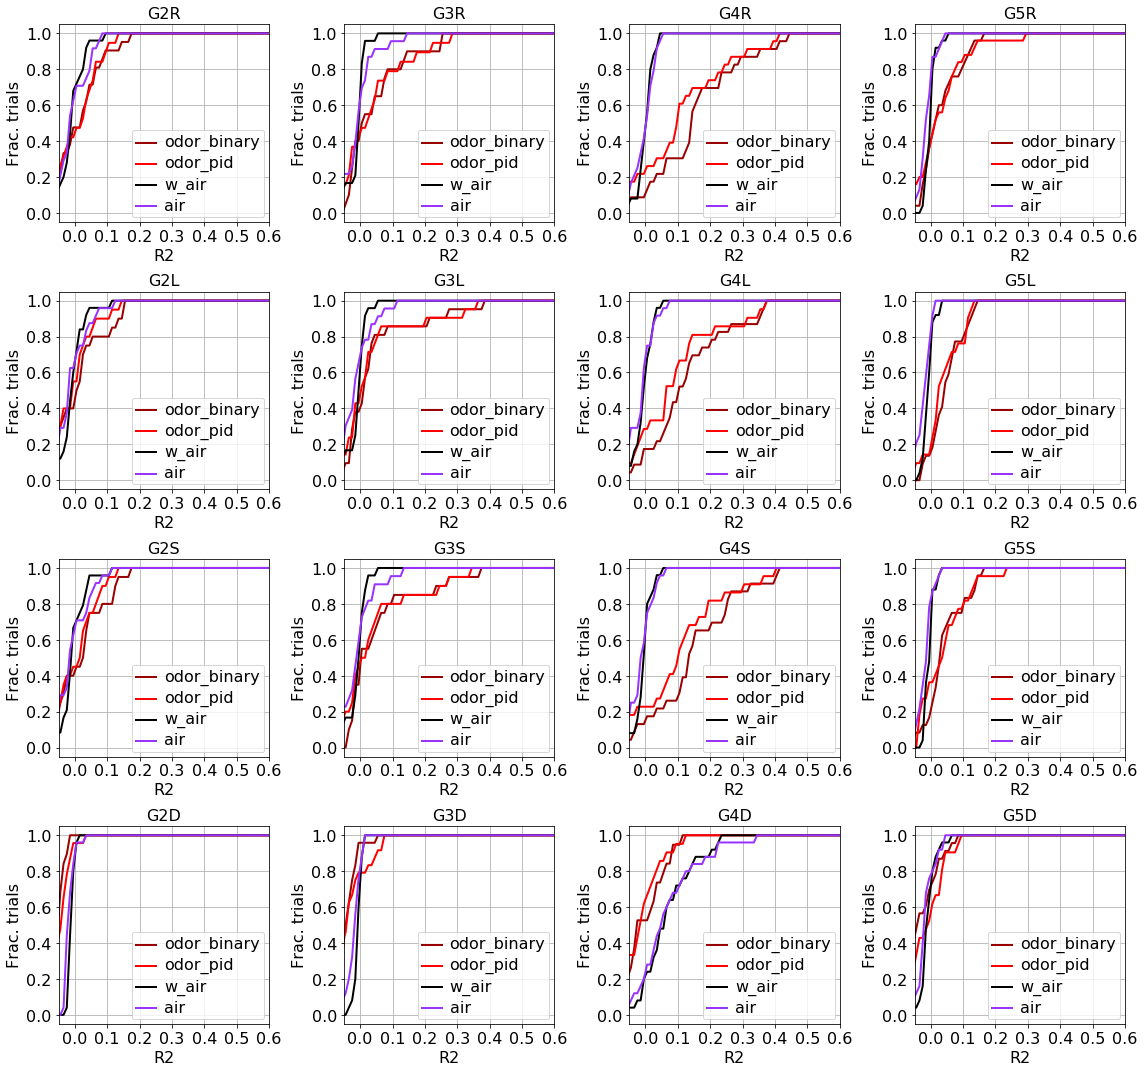

In [6]:
fig, axs = plt.subplots(4, 4, figsize=(16, 15), tight_layout=True)

for ctr, (y_name, ax) in enumerate(zip(Y_NAMES, axs.flatten())):
    for x_name in X_NAMES:
        
        # get all R2s
        r2s = df_r2[(x_name, y_name)].as_matrix()
        
        # plot cumulative histogram
        cts, bins = np.histogram(r2s, bins=BINS)
        cts = cts.cumsum().astype(float)
        cts /= cts[-1]
        
        color = COLORS[x_name]
        
        ax.plot(BINCS, cts, color=color, lw=2)
        
    ax.set_title(y_name.upper())
    
    ax.legend(X_NAMES, ncol=1, loc='best')
        
for ax in axs.flatten():
    ax.set_xlim(-0.05, 0.6)
    ax.set_ylim(-0.05, 1.05)
    
    ax.grid()
    
    ax.set_xlabel('R2')
    ax.set_ylabel('Frac. trials')
    
    set_font_size(ax, 16)

# Show table of select R2 values

In [7]:
df_r2[[('odor_binary', 'g4s'), ('odor_pid', 'g4s'), ('w_air', 'g4d'), ('air', 'g4d')]]

,"(odor_binary, g4s)","(odor_pid, g4s)","(w_air, g4d)","(air, g4d)"
20171130.Fly1.3,0.258542,0.249498,0.0695308,0.0728045
20171130.Fly1.4,0.113289,0.054681,0.131128,0.12766
20171130.Fly1.5,0.138026,0.0902283,0.227638,0.228193
20171130.Fly1.6,0.0699505,-0.0803959,0.0603969,0.0291673
20171130.Fly2.1,0.407868,0.362075,0.0489383,0.054612
20171130.Fly2.2,0.150937,0.11396,0.235319,0.342978
20171130.Fly3.3,0.10909,0.134528,0.038162,0.026809
20171130.Fly3.4,0.00768343,-0.0254406,0.0704619,0.0869462
20171130.Fly3.5,0.0365626,0.0324817,0.0257772,0.00256302
20171130.Fly3.6,0.200641,0.107136,0.0614669,0.0590654


In [8]:
df_r2[[('odor_binary', 'g4r'), ('odor_binary', 'g4l'), ('odor_binary', 'g4s')]]

,"(odor_binary, g4r)","(odor_binary, g4l)","(odor_binary, g4s)"
20171130.Fly1.3,0.27675,0.227689,0.258542
20171130.Fly1.4,0.137134,0.0862029,0.113289
20171130.Fly1.5,0.149596,0.109943,0.138026
20171130.Fly1.6,0.0616146,0.0763369,0.0699505
20171130.Fly2.1,0.440283,0.358225,0.407868
20171130.Fly2.2,0.143911,0.134658,0.150937
20171130.Fly3.3,0.121166,0.0845064,0.10909
20171130.Fly3.4,0.0122604,-0.000798597,0.00768343
20171130.Fly3.5,0.0333189,0.0329704,0.0365626
20171130.Fly3.6,0.168434,0.207619,0.200641


# Plot select filters

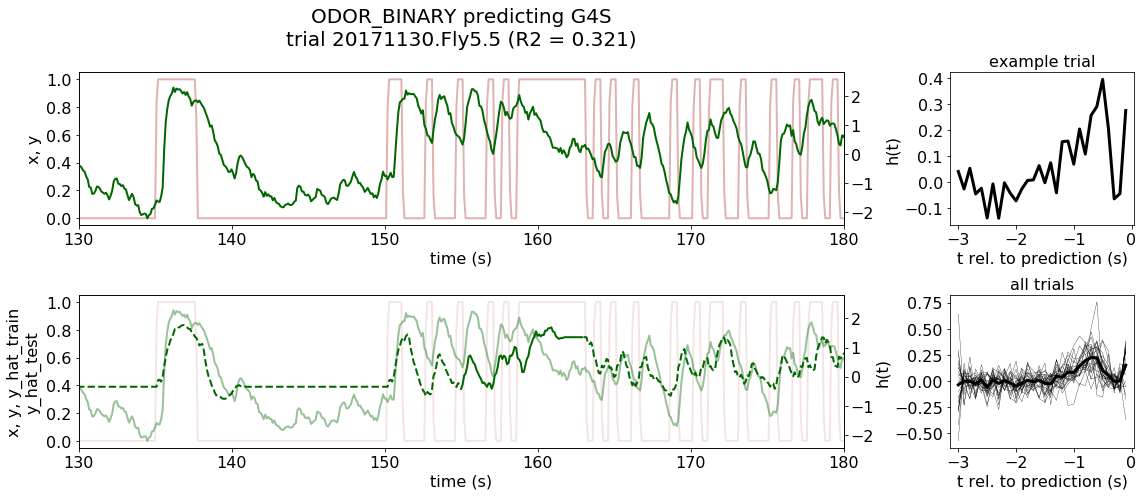

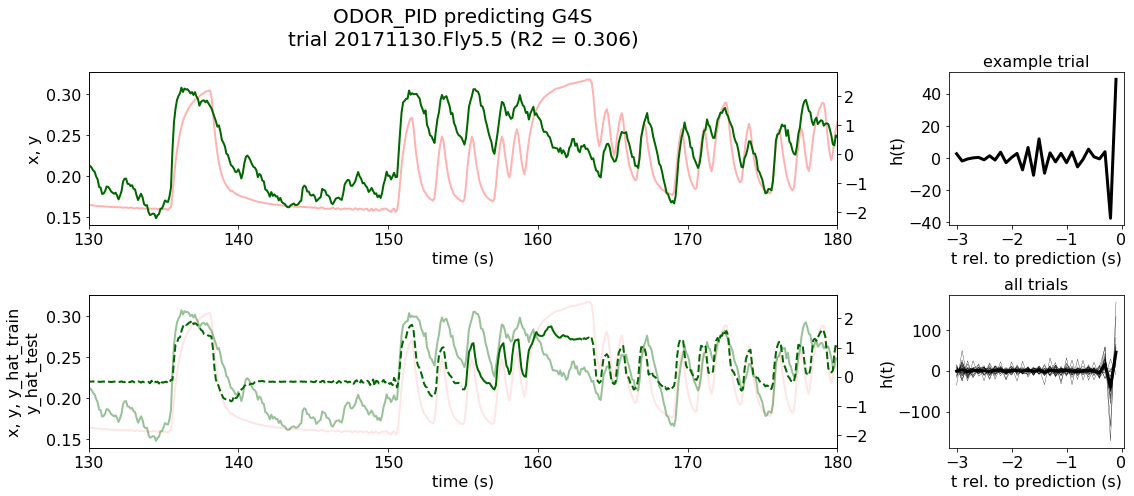

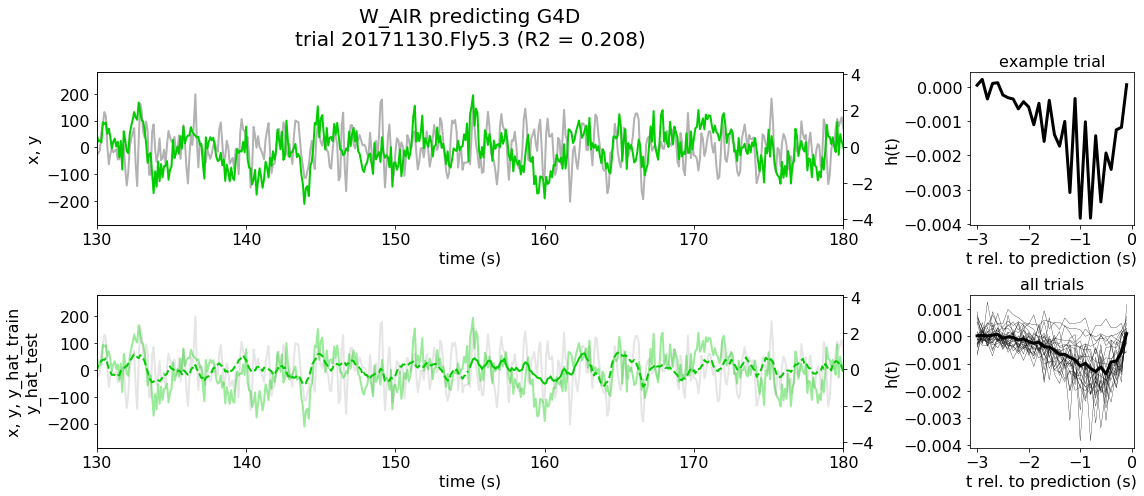

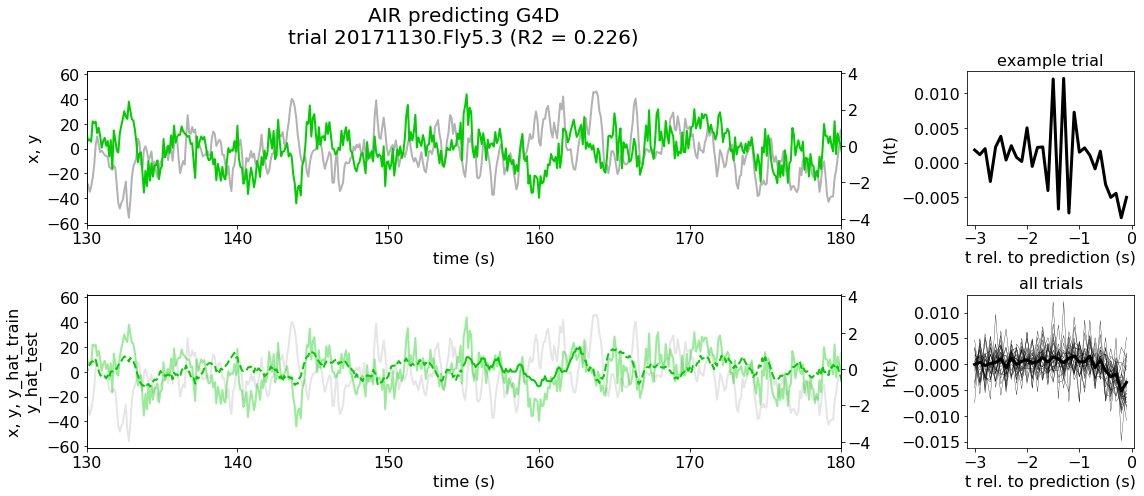

In [15]:
HS_PLOT = [
    ('20171130.Fly5.5', (130, 180), 'odor_binary', 'g4s'),
    ('20171130.Fly5.5', (130, 180), 'odor_pid', 'g4s'),
    ('20171130.Fly5.3', (130, 180), 'w_air', 'g4d'),
    ('20171130.Fly5.3', (130, 180), 'air', 'g4d'),
]

for trial_name, t_lim, x_name, y_name in HS_PLOT:
    
    rslt = df_rslt.loc[trial_name][(x_name, y_name)]
    
    c_x = np.array(C.COLORS_RGB[x_name]) / 255
    c_y = np.array(C.COLORS_RGB[y_name]) / 255
    
    gs = gridspec.GridSpec(2, 4)
    
    fig = plt.figure(figsize=(16, 7), tight_layout=True)
    
    # plot x and y
    ax_0 = fig.add_subplot(gs[0, :3])
    ax_0.plot(rslt.t, rslt.xs[x_name], color=c_x, lw=2, alpha=0.3)
    
    ax_0_twin = ax_0.twinx()
    
    ax_0_twin.plot(rslt.t, rslt.y, color=c_y, lw=2)
    
    ax_0.set_xlim(t_lim)
    
    ax_0.set_xlabel('time (s)')
    ax_0.set_ylabel('x, y')
    ax_0.set_title('{2} predicting {3}\ntrial {0} (R2 = {1:.3f})\n'.format(
        trial_name, rslt.r2_test, x_name.upper(), y_name.upper()))
    
    # plot x, y, y_hat_train, and y_hat_test
    ax_1 = fig.add_subplot(gs[1, :3])
    ax_1.plot(rslt.t, rslt.xs[x_name], color=c_x, lw=2, alpha=0.1)
    
    ax_1_twin = ax_1.twinx()
    
    ax_1_twin.plot(rslt.t, rslt.y, color=c_y, lw=2, alpha=0.4)
    ax_1_twin.plot(rslt.t, rslt.y_hat_train, color=c_y, lw=2, ls='--')
    ax_1_twin.plot(rslt.t, rslt.y_hat_test, color=c_y, lw=2, ls='-')
    
    ax_1.set_xlim(t_lim)
    
    ax_1.set_xlabel('time (s)')
    ax_1.set_ylabel('x, y, y_hat_train\ny_hat_test')
    
    # plot filters
    ## example cross-split mean + std
    t_hs, hs_mean = df_h.loc[trial_name][(x_name, y_name)]
    t_h = t_hs[x_name]
    h_mean = hs_mean[x_name]
    
    ax_2 = fig.add_subplot(gs[0, 3])
    
    ### filter corresponding to example x, y trace
    ax_2.plot(rslt.t_hs[x_name], rslt.hs[x_name], color='k', lw=1)
    
    ### mean/stds of filters across all splits
    ax_2.plot(t_h, h_mean, color='k', lw=3)
    
    ax_2.set_xlabel('t rel. to prediction (s)')
    ax_2.set_ylabel('h(t)')
    ax_2.set_title('example trial')
    
    ## cross-trial mean
    t_hs = np.array([df_h.loc[trial.name][(x_name, y_name)][0][x_name] for trial in trials])
    h_means = np.array([df_h.loc[trial.name][(x_name, y_name)][1][x_name] for trial in trials])
    
    ax_3 = fig.add_subplot(gs[1, 3])
    
    ax_3.plot(t_hs.mean(0), h_means.T, color='k', lw=0.3)
    ax_3.plot(t_hs.mean(0), h_means.mean(0), color='k', lw=3)
    
    ax_3.set_xlabel('t rel. to prediction (s)')
    ax_3.set_ylabel('h(t)')
    ax_3.set_title('all trials')
    
    for ax in [ax_0, ax_0_twin, ax_1, ax_1_twin, ax_2, ax_3]:
        set_font_size(ax, 16)
        
        if ax not in [ax_2, ax_3]:
            ax.title.set_fontsize(20)

# # TEMP

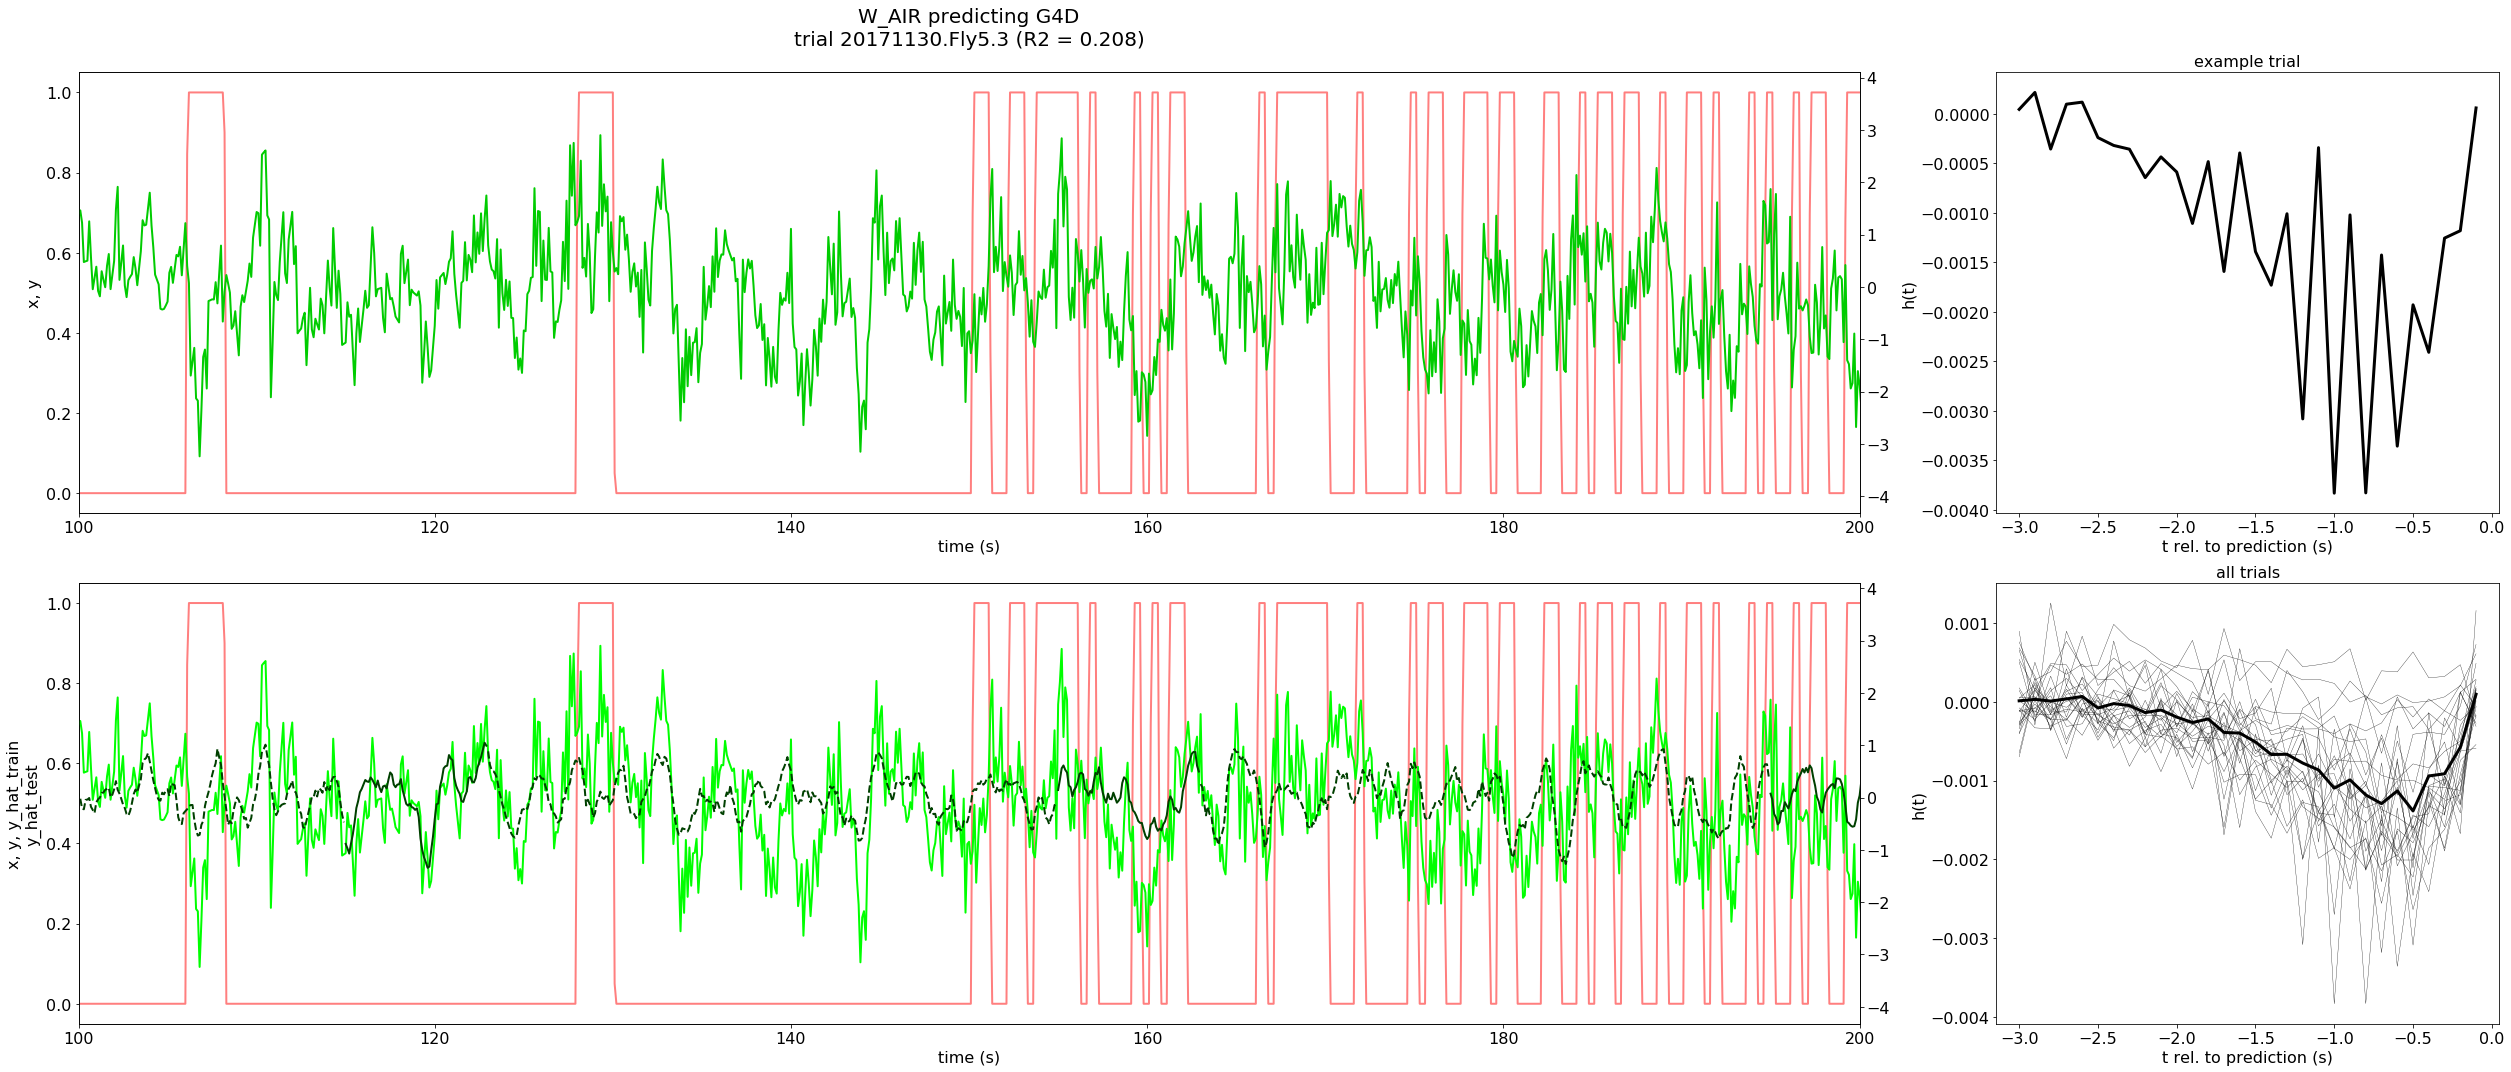

In [14]:
trial_name = '20171130.Fly5.3'
x_name = 'w_air'
y_name = 'g4d'

t_lim = (100, 200)

rslt_odor = df_rslt.loc[trial_name][('odor_binary', 'g4s')]
rslt = df_rslt.loc[trial_name][('w_air', 'g4d')]

c_x = np.array(C.COLORS_RGB[x_name]) / 255
c_y = np.array(C.COLORS_RGB[y_name]) / 255

gs = gridspec.GridSpec(2, 4)

fig = plt.figure(figsize=(35, 15), tight_layout=True)

# plot x and y
ax_0 = fig.add_subplot(gs[0, :3])
ax_0.plot(rslt_odor.t, rslt_odor.xs['odor_binary'], color='r', lw=2, alpha=0.5)

ax_0_twin = ax_0.twinx()

ax_0_twin.plot(rslt.t, rslt.y, color=c_y, lw=2)

ax_0.set_xlim(t_lim)

ax_0.set_xlabel('time (s)')
ax_0.set_ylabel('x, y')
ax_0.set_title('{2} predicting {3}\ntrial {0} (R2 = {1:.3f})\n'.format(
    trial_name, rslt.r2_test, x_name.upper(), y_name.upper()))

# plot x, y, y_hat_train, and y_hat_test
ax_1 = fig.add_subplot(gs[1, :3])
ax_1.plot(rslt_odor.t, rslt_odor.xs['odor_binary'], color='r', lw=2, alpha=0.5)

ax_1_twin = ax_1.twinx()

ax_1_twin.plot(rslt.t, rslt.y, color=(0, 1, 0), lw=2, alpha=1)
ax_1_twin.plot(rslt.t, rslt.y_hat_train, color=(0, .25, 0), lw=2, ls='--')
ax_1_twin.plot(rslt.t, rslt.y_hat_test, color=(0, .25, 0), lw=2, ls='-')

ax_1.set_xlim(t_lim)

ax_1.set_xlabel('time (s)')
ax_1.set_ylabel('x, y, y_hat_train\ny_hat_test')

# plot filters
## example cross-split mean + std
t_hs, hs_mean = df_h.loc[trial_name][(x_name, y_name)]
t_h = t_hs[x_name]
h_mean = hs_mean[x_name]

ax_2 = fig.add_subplot(gs[0, 3])

### filter corresponding to example x, y trace
ax_2.plot(rslt.t_hs[x_name], rslt.hs[x_name], color='k', lw=1)

### mean/stds of filters across all splits
ax_2.plot(t_h, h_mean, color='k', lw=3)

ax_2.set_xlabel('t rel. to prediction (s)')
ax_2.set_ylabel('h(t)')
ax_2.set_title('example trial')

## cross-trial mean
t_hs = np.array([df_h.loc[trial.name][(x_name, y_name)][0][x_name] for trial in trials])
h_means = np.array([df_h.loc[trial.name][(x_name, y_name)][1][x_name] for trial in trials])

ax_3 = fig.add_subplot(gs[1, 3])

ax_3.plot(t_hs.mean(0), h_means.T, color='k', lw=0.3)
ax_3.plot(t_hs.mean(0), h_means.mean(0), color='k', lw=3)

ax_3.set_xlabel('t rel. to prediction (s)')
ax_3.set_ylabel('h(t)')
ax_3.set_title('all trials')

for ax in [ax_0, ax_0_twin, ax_1, ax_1_twin, ax_2, ax_3]:
    set_font_size(ax, 16)

    if ax not in [ax_2, ax_3]:
        ax.title.set_fontsize(20)

In [15]:
fig.savefig('temp.png', dpi=300)

# # END TEMP

### Plot per-trial W_AIR --> G4D filters and R2 values

We do this to confirm that low R2s correspond to ugly filters.

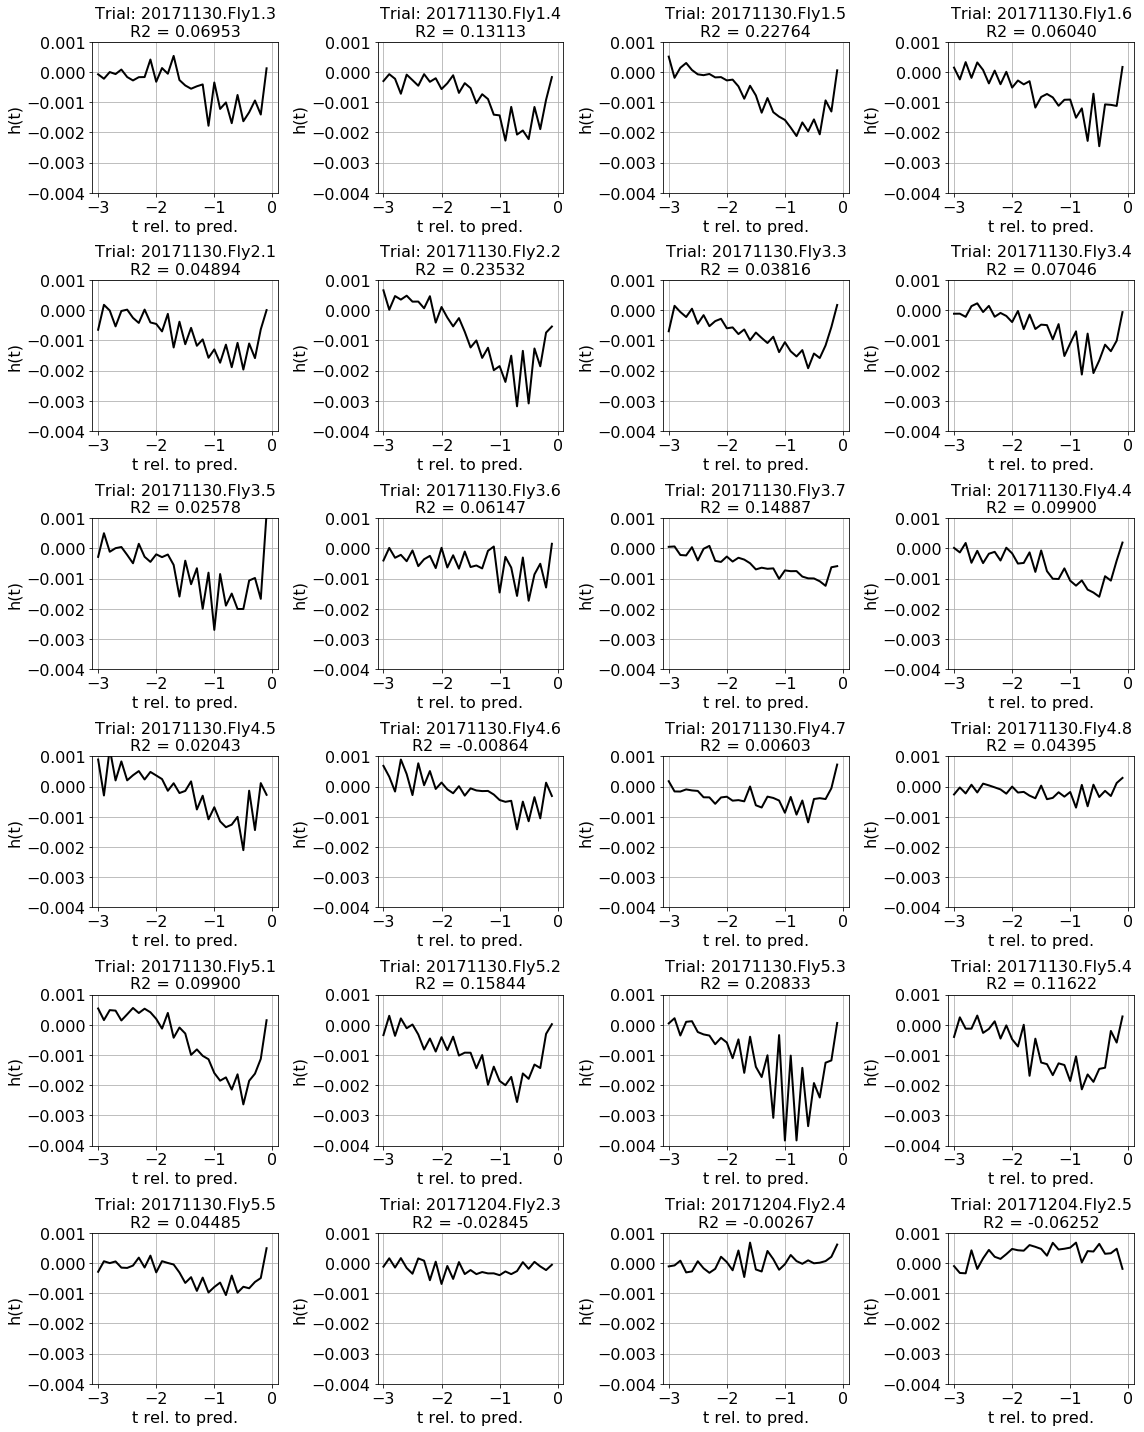

In [16]:
X_NAME = 'w_air'
Y_NAME = 'g4d'

fig, axs = plt.subplots(6, 4, figsize=(16, 20), tight_layout=True)

for trial, ax in zip(trials, axs.flatten()):
    
    t_h = df_h.loc[trial.name][(X_NAME, Y_NAME)][0][X_NAME]
    h_mean = df_h.loc[trial.name][(X_NAME, Y_NAME)][1][X_NAME]
    r2 = df_r2.loc[trial.name][(X_NAME, Y_NAME)]
    
    ax.plot(t_h, h_mean, lw=2, c='k')
    ax.set_title('Trial: {0}\nR2 = {1:.5f}'.format(trial.name, r2))
    
for ax in axs.flatten():
    
    ax.set_xlim(-3.1, 0.1)
    ax.set_ylim(-0.004, 0.001)
    
    ax.grid()
    
    ax.set_xlabel('t rel. to pred.')
    ax.set_ylabel('h(t)')
    
    set_font_size(ax, 16)